# Transform CoLoRE outputs to Lya skewer

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import lya_mock_functions as mock

In [3]:
def flux_stats(flux,z,z_qso):
    Nz=len(z)
    print('Nz =',Nz)
    Nq=len(z_qso)
    print('Nq =',Nq)
    mean_flux=np.zeros(Nz)
    var_flux=np.zeros(Nz)
    weight=np.zeros(Nz)
    for i in range(Nq):
        if min(z) > z_qso[i]: continue
        mask=z < z_qso[i]
        mean_flux[mask] += flux[i][mask]
        var_flux[mask] += flux[i][mask]**2
        weight[mask] += 1
    for i in range(Nz):
        if weight[i]>0:
            mean_flux[i]/=weight[i]
            var_flux[i]/=weight[i]
            var_flux[i]-=mean_flux[i]**2
    return mean_flux,var_flux

In [4]:
def get_sigma2(catalog,delta_density,z,D,zmin):
    print('original shape',delta_density.shape)
    # select only high-z quasars 
    low_z = catalog['Z_COSMO'] < zmin
    good_qso = np.invert(low_z)
    good_qso = np.where(good_qso)[0]
    catalog = catalog[good_qso]
    print('# high-z quasars =',len(catalog))
    delta_density = delta_density[good_qso]
    # get rid of high-z pixels
    z_mean = z < zmin
    z_mean = np.where(z_mean)[0]
    delta_density = delta_density[:,z_mean]
    z = z[z_mean]
    print('final shape',delta_density.shape)
    D = D[z_mean]
    log_density = np.log(1.0+delta_density)
    mean_log = np.mean(log_density,axis=0)
    sig2=np.mean(-2*mean_log/D/D)
    print('sigma^2 =',sig2)
    return sig2

In [7]:
# open data file (test file with few quasars)
#filename='/Users/font/Projects/DESI/desi_lya_mocks/Sims/NERSC_Lya4096/output_colore/out_srcs_s0_0.fits'
filename='/Users/jfarr/Projects/LyaCoLoRe/example_data/raw_colore/N1000_out_srcs_s0_15.fits'
h = fitsio.FITS(filename)

In [8]:
cosmo=h[4].read()
z = cosmo['Z']
R = cosmo['R']
D = cosmo['D']
Nz=len(z)
#plt.plot(z,D)

In [9]:
# read catalog 
catalog = h[1].read()
print('# quasars at start =',len(catalog))
# get deltas (fluctuation around mean density) and line of sight velocity (actually, dz)
delta_density = h[2].read()
velocity = h[3].read()
# get rid of bad qso
bad_dec = np.isnan(catalog['DEC']) | (catalog['DEC'] < -90.0) | (catalog['DEC'] > 90.0)
#bad_dec = np.isnan(catalog['DEC']) | (catalog['DEC'] < -5.0) | (catalog['DEC'] > 5.0)
good_dec = np.invert(bad_dec)
good_dec = np.where(good_dec)[0]
catalog = catalog[good_dec]
print('# quasars at end =',len(catalog))
delta_density = delta_density[good_dec]
velocity = velocity[good_dec]
# get information about quasars (TYPE,RA,DEC,Z_COSMO,DZ_RSD)
z_qso = catalog['Z_COSMO']
Nq = len(z_qso)
print(np.min(z_qso),'< z_qso <',np.max(z_qso))

# quasars at start = 1000
# quasars at end = 1000
0.139725 < z_qso < 3.48193


In [10]:
zmin=1.5
sig2 = get_sigma2(catalog,delta_density,z,D,zmin)
#print('sigma^2 =',sig2)

original shape (1000, 2048)
# high-z quasars = 616
final shape (616, 1273)
sigma^2 = 1.06491


In [11]:
mask = delta_density > -1e10
for iq in range(Nq):
    mask[iq] = z < z_qso[iq]

In [12]:
log_density = np.zeros_like(delta_density)
log_density[mask] = np.log(1.0+delta_density[mask])
temp_delta_gauss = (log_density + 0.5*sig2*D*D)/D
mean_gauss = np.mean(temp_delta_gauss[mask])
print('temp mean =',mean_gauss)
delta_gauss = np.zeros_like(temp_delta_gauss)
delta_gauss[mask] = (1+temp_delta_gauss[mask])/(1+mean_gauss)-1.0
print('mean delta =',np.mean(delta_gauss))

temp mean = 0.00328349
mean delta = -5.69224e-09


In [13]:
# Convert density to flux
mock_maker=mock.MockMaker()
extra_z = mock_maker.get_redshifts()

In [14]:
# get Nq skewers 
extra_delta, extra_var = mock_maker.get_gaussian_fields(Nq)
print('mean delta =', np.mean(extra_delta))
print('var delta =', np.var(extra_delta))
print('expected var delta =',extra_var)
#plt.plot(extra_z,extra_delta[0])
#plt.xlabel('z')
#plt.ylabel('Gaussian field')

mean delta = -0.000279433810104
var delta = 2.86493080441
expected var delta = 2.86904840747


In [15]:
# define final grid and interpolate
lya=1215.67
zmax=np.min([np.max(extra_z),np.max(z)])
lmin=3500
lmax=lya*(1+zmax)
print(lmin,'< l <',lmax)
dl=0.1
final_wave=np.arange(lmin,lmax,dl)
final_z=final_wave/lya-1.0
Nl=len(final_wave)
final_delta=np.zeros([Nq,Nl])
for i in range(Nq):
    final_mask = final_wave < lya *(1+z_qso[i])
    int_colore = np.interp(final_wave[final_mask],z,delta_gauss[i])
    int_p1d = np.interp(final_wave[final_mask],lya*(1+extra_z),extra_delta[i])
    final_delta[i][final_mask] = int_colore + int_p1d

3500 < l < 5820.23767764


In [16]:
# from delta to flux
density = mock_maker.get_density(extra_var+sig2,final_z,final_delta)
#density = mock_maker.get_density(extra_var,final_z,final_delta)
print('mean density =', np.mean(density))
print('var density =', np.var(density))
#plt.semilogy(final_z,density[-1])
#plt.xlabel('z')
#plt.ylabel('density')

mean density = 0.573104793183
var density = 3615.7424093


In [17]:
tau = mock.get_tau(final_z,density)
print('mean tau =', np.mean(tau))
print('var tau =', np.var(tau))
#plt.semilogy(final_z,tau[-1])
#plt.xlabel('z')
#plt.ylabel('optical depth')

mean tau = 0.148020336268
var tau = 37.1403938986


In [18]:
flux = np.exp(-tau)
print('mean flux =', np.mean(flux))
print('var flux =', np.var(flux))
#plt.plot(final_z,flux[-1])
#plt.xlabel('z')
#plt.ylabel('transmitted flux fraction')
#plt.xlim(3.0,3.2)

mean flux = 0.904635717555
var flux = 0.0128206641513


In [19]:
mean_flux,var_flux=flux_stats(flux,final_z,z_qso)

Nz = 23203
Nq = 1000


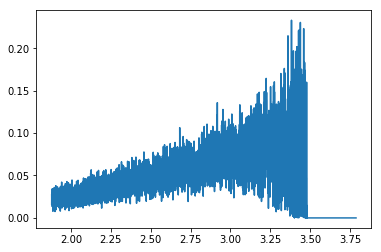

In [20]:
plt.plot(final_z,var_flux)

(0.4, 1.0)

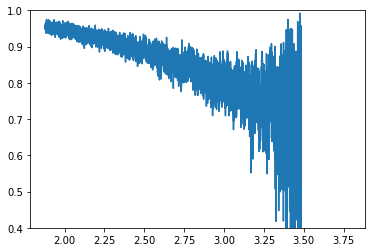

In [21]:
plt.plot(final_z,mean_flux)
plt.ylim(0.4,1.0)